In [235]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
import utils.data
from generators.synthetic_generators import *
from generators.ESN import ESNGenerator
from sigkernel_.loss import compute_mmd_loss
from sigkernel_.kernels import gram
from utils.kernel_helpers import median_heuristic_sigma

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generator and ESN

In [236]:
# Generator and ESN details ----------------------
T = 200 # length of time series
N = 20  # number of samples
d = 1   # dimension of time series
p = 2   # AR order
q = 0   # MA order
phi = [0.7, -0.2] # AR coefficients
theta = None # MA coefficients

h, m, d = 500, 20, 1 # ESN hyperparameters: reservoir size, input dimension, output dimension
A = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
C = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix

# Define data generator and esn
target_generator = ARMA(T=T, p=p, q=q, phi=phi, theta=theta)
esn = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05)

# Generate examples

In [237]:
with torch.no_grad():
    X = target_generator.generate(N=N, noise=Noise("normal")).to(device=device, dtype=dtype)
    Z = esn(T=T, N=N).to(device=device, dtype=dtype)
print(f"Generated data shapes: X: {X.shape}, Z: {Z.shape}")

Generated data shapes: X: torch.Size([20, 200, 1]), Z: torch.Size([20, 200, 1])


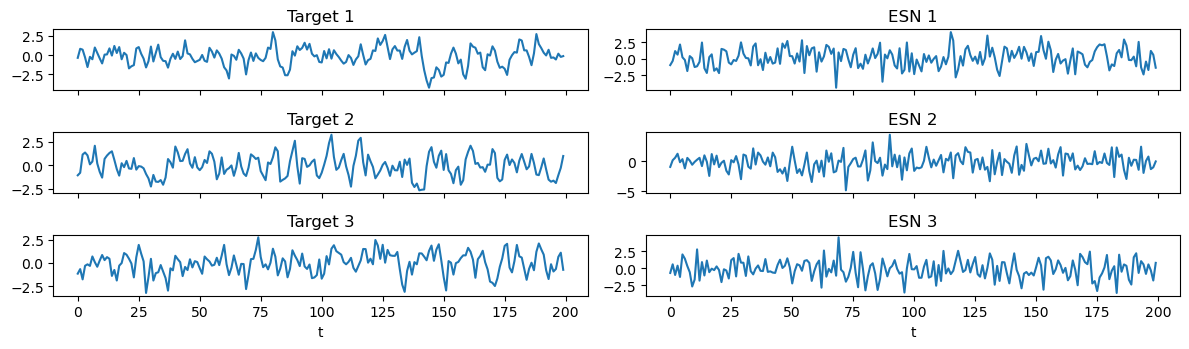

In [238]:
# visualize the current generators
n_examples = 3
fig, axes = plt.subplots(nrows=n_examples, ncols=2, figsize=(12, 1.2 * n_examples), sharex=True)
if n_examples == 1:
    axes = axes.reshape(1, 2)

for i in range(n_examples):
    axes[i, 0].plot(X[i, :, 0].numpy())
    axes[i, 0].set_title(f"Target {i+1}")
    axes[i, 1].plot(Z[i, :, 0].numpy())
    axes[i, 1].set_title(f"ESN {i+1}")
for ax in axes[-1, :]:
    ax.set_xlabel("t")
plt.tight_layout()
plt.show()

# Kernels

In [239]:
median_heuristic_sigma = median_heuristic_sigma(X, Z)
print(f"Median heuristic sigma: {median_heuristic_sigma:.4f}")

# Define the discretized signature kernel
static_kernel_type_disc    = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels              = 10 # number of levels in the truncated signature kernel
disc_sig_kernel_sigma = 1e-3 # bandwidth parameter for the static kernel

kwargs_disc_sig = {
    'static_kernel_type': static_kernel_type_disc,
    'n_levels': n_levels,
    'kernel_sigma': disc_sig_kernel_sigma,
}

sig_disc_kernel = ksig_disc.kernels.get_discretized_signature_kernel(**kwargs_disc_sig)

#---------------------------------
# Define the pde signature kernel
pde_sig_sigma = median_heuristic_sigma # bandwidth parameter for the static kernel
static_kernel_pde = ksig_pde.RBFKernel(sigma=pde_sig_sigma) # define static kernel

# Initialize the corresponding signature kernel
sig_pde_kernel = ksig_pde.SigKernel(static_kernel_pde, dyadic_order=0)

#---------------------------------
# Define static kernel
static_sigma = median_heuristic_sigma
rbf_kernel = ksig_disc.kernels.RBFKernel(sigma=static_sigma)

Median heuristic sigma: 26.5494


# RBF

In [240]:
rbf_gram = gram(rbf_kernel, X.reshape(X.shape[0], -1), Z.reshape(Z.shape[0], -1))
print("RBF Gram matrix stats:")
print(f"Shape: {rbf_gram.shape}")
print(f"Min: {rbf_gram.min().item():.4f}")
print(f"Max: {rbf_gram.max().item():.4f}")
print(f"Mean: {rbf_gram.mean().item():.4f}")
print(f"Std: {rbf_gram.std().item():.4f}")

print("First 3 rows and columns of RBF Gram matrix:")
print(rbf_gram[:3, :3])

RBF Gram matrix stats:
Shape: torch.Size([20, 20])
Min: 0.2289
Max: 0.4697
Mean: 0.3699
Std: 0.0355
First 3 rows and columns of RBF Gram matrix:
tensor([[0.3159, 0.3581, 0.4129],
        [0.3789, 0.3402, 0.3776],
        [0.3868, 0.3843, 0.3554]], dtype=torch.float64)


In [241]:
mmd_rbf = compute_mmd_loss(rbf_kernel, X.reshape(X.shape[0], -1), Z.reshape(Z.shape[0], -1))
print(f"MMD (RBF kernel): {mmd_rbf.item():.6f}")

MMD (RBF kernel): 0.006068


# SIG-PDE

In [242]:
sig_pde_gram = gram(sig_pde_kernel, X, Z)
print("sig_pde Gram matrix stats:")
print(f"Shape: {sig_pde_gram.shape}")
print(f"Min: {sig_pde_gram.min().item():.4f}")
print(f"Max: {sig_pde_gram.max().item():.4f}")
print(f"Mean: {sig_pde_gram.mean().item():.4f}")
print(f"Std: {sig_pde_gram.std().item():.4f}")

print("First 3 rows and columns of sig_pde Gram matrix:")
print(sig_pde_gram[:3, :3])

sig_pde Gram matrix stats:
Shape: torch.Size([20, 20])
Min: 0.1985
Max: 2.5273
Mean: 1.2846
Std: 0.3646
First 3 rows and columns of sig_pde Gram matrix:
tensor([[0.7743, 0.9081, 1.2609],
        [1.7089, 1.9060, 1.2471],
        [1.6433, 1.6661, 1.0409]], dtype=torch.float64)


In [243]:
mmd_sig_pde = compute_mmd_loss(sig_pde_kernel, X, Z)
print(f"MMD (sig_pde kernel): {mmd_sig_pde.item():.6f}")

MMD (sig_pde kernel): 1.701454


# SIG-DISC

In [244]:
sig_disc_gram = gram(sig_disc_kernel, X, Z)
print("sig_disc Gram matrix stats:")
print(f"Shape: {sig_disc_gram.shape}")
print(f"Min: {sig_disc_gram.min().item():.4f}")
print(f"Max: {sig_disc_gram.max().item():.4f}")
print(f"Mean: {sig_disc_gram.mean().item():.4f}")
print(f"Std: {sig_disc_gram.std().item():.4f}")

print("First 3 rows and columns of sig_disc Gram matrix:")
print(sig_disc_gram[:3, :3])

sig_disc Gram matrix stats:
Shape: torch.Size([20, 20])
Min: 58.6719
Max: 4739.9059
Mean: 525.0201
Std: 464.9091
First 3 rows and columns of sig_disc Gram matrix:
tensor([[ 309.5668,  381.2739,  971.2976],
        [ 304.8059,  178.4669, 1188.6950],
        [ 308.8081, 1076.5610,  116.4001]], dtype=torch.float64)


In [245]:
mmd_sig_disc = compute_mmd_loss(sig_disc_kernel, X, Z)
print(f"MMD (sig_disc kernel): {mmd_sig_disc.item():.6f}")

MMD (sig_disc kernel): 143.021547
